In [1]:
from ctapipe.io import read_table
import tables
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

from ctapipe.instrument import CameraGeometry, SubarrayDescription
from ctapipe.visualization import CameraDisplay
from ctapipe.coordinates import EngineeringCameraFrame

In [2]:
input_file = "datacheck_dl1_LST-1.Run13629.h5"

In [3]:
b = tables.open_file(input_file)
b.root.dl1datacheck

/dl1datacheck (Group) ''
  children := ['cosmics' (Table), 'flatfield' (Table), 'histogram_binning' (Table), 'pedestals' (Table), 'used_trigger_tag' (Array)]

One table for each event type: cosmics, (interleaved) flatfield and (interleaved) pedestals. Each of those three tables has as many rows as sub-runs in the run (135 for run 13629) 

Some of the columns, those named as hist_*, are arrays (one per subrun) which contain the contents of a 1-D or 2-D histogram - the binnings are defined in the histogram_binning table. When not specified in the column name, the x-axis of 2-D histos is intensity

In [4]:
b.root.dl1datacheck.cosmics.colnames

['subrun_index',
 'elapsed_time',
 'num_events',
 'num_cleaned_events',
 'trigger_type',
 'ucts_trigger_type',
 'num_ucts_jumps',
 'mean_alt_tel',
 'mean_az_tel',
 'tel_ra',
 'tel_dec',
 'sampled_event_ids',
 'ucts_time',
 'tib_time',
 'dragon_time',
 'hist_delta_t',
 'hist_npixels',
 'hist_nislands',
 'hist_intensity',
 'hist_dist0',
 'hist_dist0_intensity_gt_200',
 'hist_width',
 'hist_length',
 'hist_skewness',
 'hist_pixelchargespectrum',
 'hist_psi',
 'hist_intercept',
 'hist_tgrad_vs_length',
 'hist_tgrad_vs_length_intensity_gt_200',
 'cog_within_pixel',
 'cog_within_pixel_intensity_gt_200',
 'num_nearby_stars',
 'charge_mean',
 'charge_stddev',
 'time_mean',
 'time_stddev',
 'time_mean_above_030_pe',
 'time_stddev_above_030_pe',
 'relative_time_mean',
 'relative_time_stddev',
 'num_pulses_above_0010_pe',
 'num_pulses_above_0030_pe',
 'num_pulses_above_0100_pe',
 'num_pulses_above_0300_pe',
 'num_pulses_above_1000_pe']

In [5]:
b.root.dl1datacheck.histogram_binning.cols

/dl1datacheck/histogram_binning.cols (Cols), 15 columns
  hist_delta_t (Column(1, 200), ('<f8', (200,)))
  hist_pixelchargespectrum (Column(1, 121), ('<f8', (121,)))
  hist_intensity (Column(1, 101), ('<f8', (101,)))
  hist_dist0 (Column(1, 50), ('<f8', (50,)))
  hist_dist0_intensity_gt_200 (Column(1, 50), ('<f8', (50,)))
  hist_psi (Column(1, 101), ('<f8', (101,)))
  hist_psi_intensity_gt_200 (Column(1, 101), ('<f8', (101,)))
  hist_nislands (Column(1, 31), ('<f8', (31,)))
  hist_npixels (Column(1, 400), ('<f8', (400,)))
  hist_width (Column(1, 2, 101), ('<f8', (2, 101)))
  hist_length (Column(1, 2, 101), ('<f8', (2, 101)))
  hist_skewness (Column(1, 2, 101), ('<f8', (2, 101)))
  hist_tgrad_vs_length (Column(1, 2, 101), ('<f8', (2, 101)))
  hist_tgrad_vs_length_intensity_gt_200 (Column(1, 2, 101), ('<f8', (2, 101)))
  hist_intercept (Column(1, 2, 101), ('<f8', (2, 101)))

In [6]:
hi = b.root.dl1datacheck.cosmics.col('hist_intensity')  # histogram bin contents

bhi = b.root.dl1datacheck.histogram_binning.col('hist_intensity')[0] 
# ^^^ histogram bin edges (can't recall why all these binning columns have one additional dimension - just take element 0!)

num_triggered = b.root.dl1datacheck.cosmics.col('num_events')
elapsed_t = b.root.dl1datacheck.cosmics.col('elapsed_time')
index = b.root.dl1datacheck.cosmics.col('subrun_index')
dragon_time = b.root.dl1datacheck.cosmics.col('dragon_time')
alt_tel = np.rad2deg(b.root.dl1datacheck.cosmics.col('mean_alt_tel'))
az_tel = np.rad2deg(b.root.dl1datacheck.cosmics.col('mean_az_tel'))

In [7]:
# We keep 50 timestamps per subrun, at regular intervals. Calculate the mean of then as "time of the subrun" and convert to utc:
utctime = np.array([datetime.utcfromtimestamp(x) for x in np.mean(dragon_time, axis=1)])

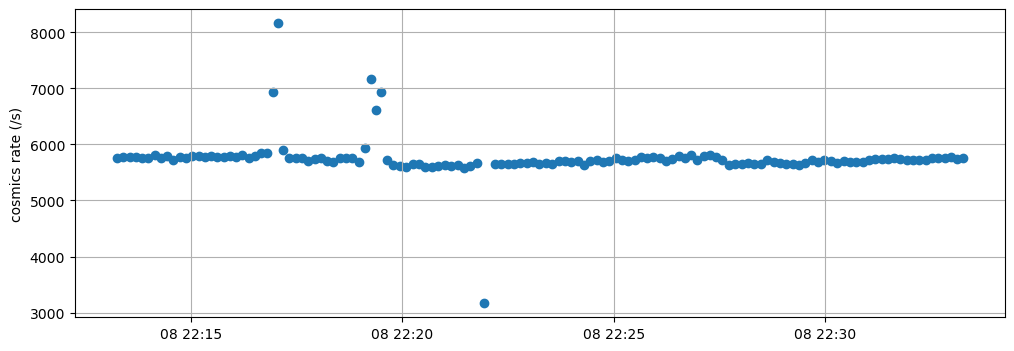

Too high rates, subruns: [25 26 41 42 43]


In [8]:
plt.figure(figsize=(12,4))
plt.scatter(utctime, num_triggered/elapsed_t)
plt.grid()
plt.ylabel('cosmics rate (/s)')
plt.show()

print('Too high rates, subruns:', index[num_triggered/elapsed_t>6300])


As for the low rate, the night's log reports  a technical issue of the DAQ: "22:22 : Drop in Camera rates, spike in busy"


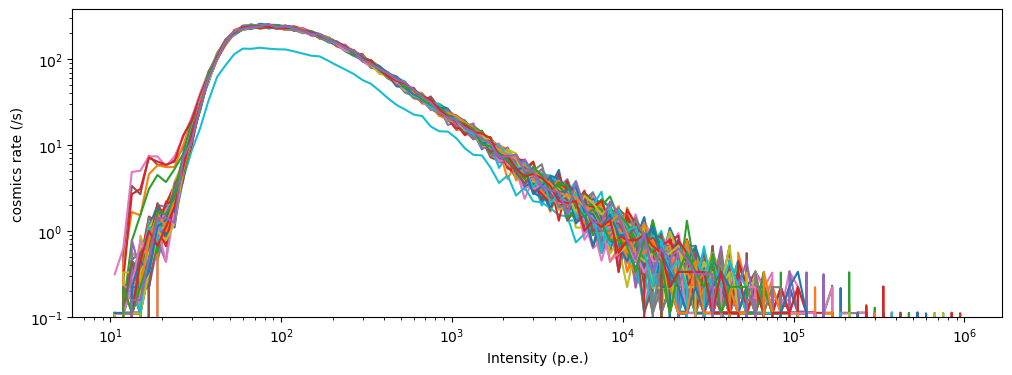

In [9]:
# intensity spectrum per subrun

plt.figure(figsize=(12,4))
for j in range(len(hi)):
    bin_centers = 0.5*(bhi[1:]+bhi[:-1])
    plt.plot(bin_centers, (hi[j]/elapsed_t[j]))
plt.ylim(0.1, 1.5*np.max(hi[j]/elapsed_t[j]))
plt.xlabel('Intensity (p.e.)')
plt.ylabel('cosmics rate (/s)')
plt.xscale('log')
plt.yscale('log')
plt.show()

The subrun with the DAQ issue is a clear outlier. 

Five subruns have anomalous (high) rate below 30 p.e. They are the same with high rates - it shows that only a small fraction of those additional triggers survived cleaning. Could be e.g. 2 faint satellites crossing the camera?

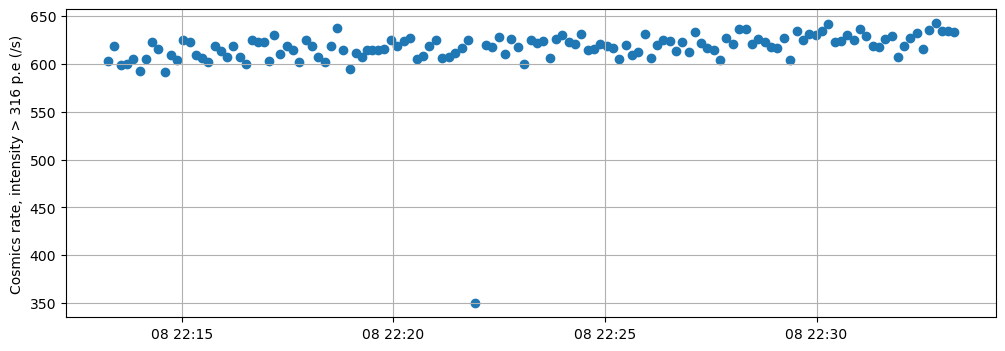

In [10]:
# Now check the rate for intensity above ~300 p.e. (bin 30 onwards), as a measure of the atmospheric quality
# (Cherenkov transparency coefficient)
#
# A quantity like this can be used not just to select periods of good quality data, but possibly also to introduce corrections. 
# The variations seen here (subrun to subrun, so just ~9 s per point) are most likely just fluctuations, but there are longer-timescale
# variations due to the atmosphere, or to the telescope (e.g. occasional miasligned mirrors)
#
plt.figure(figsize=(12,4))
plt.scatter(utctime, np.sum(hi[:,30:], axis=1)/elapsed_t)
plt.ylabel(f'Cosmics rate, intensity > {bhi[30]:.0f} p.e (/s)')
plt.grid()
plt.show()

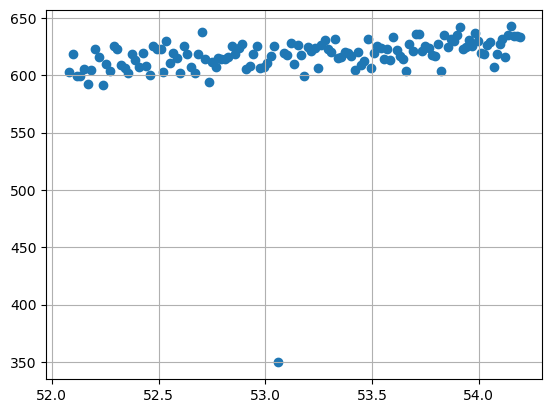

In [11]:
# Dependence with telescope pointing should be taken into account, estimated from a large datasample 
# (with just this run we cannot actually exclude that the dependence with telescope Alt, shown below, is related 
# with atmospheric changes:

plt.scatter(alt_tel, np.sum(hi[:,30:], axis=1)/elapsed_t)
plt.grid()
plt.show()

In [12]:
# Use provided file lst_description.h5 (couldn't find other way of getting the right LST1 camera geometry with ctapipe):
subarray_description = SubarrayDescription.from_hdf("lst_description.h5")
geom = subarray_description.tel[1].camera.geometry
engineering_geom = geom.transform_to(EngineeringCameraFrame())

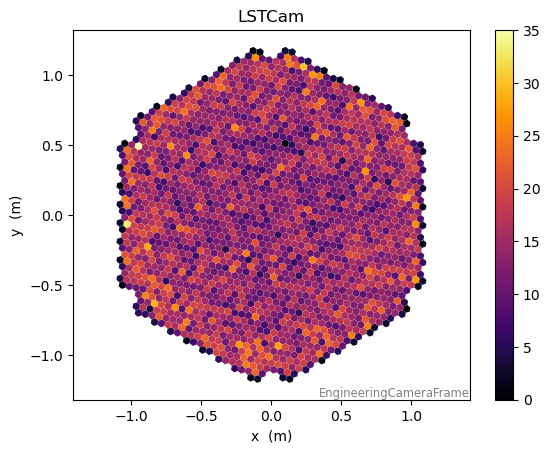

In [13]:
# Check one of the sub-runs with high rates of dim events:
# Distribution of COG across the camera (we use the counts of the number of image COGs falling within each pixel)
cog_distribution = b.root.dl1datacheck.cosmics.col('cog_within_pixel')[26]

camdisplay = CameraDisplay(engineering_geom, cog_distribution)
camdisplay.add_colorbar()

# Nothing suspicious, but note that very few of the weird additional events survived cleaning, O(10) in a subrun... one should do the 
# same for very low intensitites - but this is not among the stored quantities in the datacheck.